In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt


## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams["font.size"] = "12"
plt.rcParams['mathtext.fontset'] = 'cm'

latex_colwidth = 426.79135
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0):
      """Parameters:
        - wf [float]:  width fraction in columnwidth units
        - hf [float]:  height fraction in columnwidth units.
                       Set by default to golden ratio.
        - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                               using \showthe\columnwidth
      Returns:  [fig_width,fig_height]: that should be given to matplotlib
      """
      fig_width_pt = columnwidth*wf 
      inches_per_pt = 1.0/72.27               # Convert pt to inch
      fig_width = fig_width_pt*inches_per_pt  # width in inches
      fig_height = fig_width*hf      # height in inches
      return [fig_width, fig_height]

0.041666666666666664


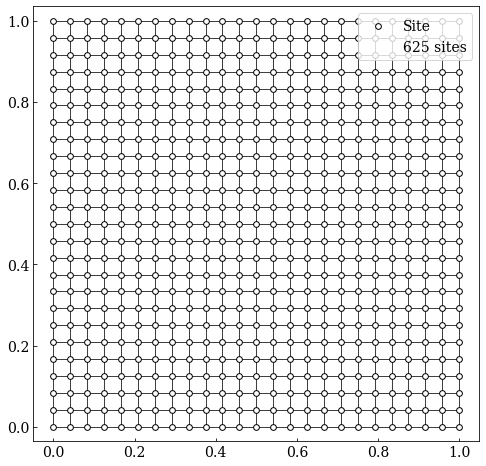

In [2]:
# We want to generate a periodic grid lattice that is 25 x 25
# Do the initial build within a unit square in the 1st quadrant
edge_points = np.linspace(0,1,25)
# Now we generate a list of lists of points
list_of_lists = [[(x,y) for y in edge_points] for x in edge_points]
points = [ele for sublist in list_of_lists for ele in sublist]

# We now find the shortest distance between point (0,0) and neighbours to establish a jump distance
smallest_dist0 = min([np.linalg.norm(np.array(points[0]) - np.array(x)) for x in points if np.linalg.norm(x) > 0])

def jump_finder(input_list, grain):
    # Define empty possible jumps
    total_jumps = []
    jump_indices = []
    for i in input_list:
        # Calculate every jump for every point
        jumps = [x for x in input_list if smallest_dist0 - 1*10**(-grain) < np.linalg.norm( np.array(i) - np.array(x) ) < smallest_dist0 + 1*10**(-grain)]
        # Find index of site to which we may jump
        indices = [j for j in range(len(input_list)) for y in jumps if input_list[j] == y]
        # Append to main lists
        total_jumps.append(jumps)
        jump_indices.append(indices)
    return total_jumps, jump_indices

jump_coors, jump_indices = jump_finder(points, 6)

xs = [x for (x,y) in points]
ys = [y for (x,y) in points]


fig, ax = plt.subplots(figsize= (8,8))

marker_size = 33

number_of_sites = len(points)

ax.scatter(x= xs, y= ys, s= marker_size, facecolor= 'w', edgecolor= 'k', label= 'Site',zorder=2)

for i,j in zip(points,jump_coors):
    xs = [x for x,y in j]
    ys = [y for x,y in j]
    for l,k in zip(xs,ys):
        ax.plot([i[0],l], [i[1],k], color= 'k', linewidth= 0.5, zorder= 1)

ax.scatter(x= [], y= [], marker= '', label= f'{number_of_sites} sites')


ax.legend(loc= 1)
ax.axis('equal')

print(smallest_dist0)
plt.show()

In [3]:
def Hamil_solve(grid_coor, jump_coor, jump_ind, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(grid_coor)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    l = smallest_dist0
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(grid_coor, jump_coor):
        products = [i[0]*k[1] - k[0]*i[1] for k in j]
        jump_products.append(products)
    phase_factors = []
    for x, y in zip(grid_coor, jump_products):
        phases = [(phi/(2 * l**2)) * s for s in y]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_ind, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues
    eig_vals, eig_vecs = np.linalg.eigh(H)
    return eig_vals, eig_vecs

# Calculate eigenvalues for varying B field strength
#Bs = np.linspace(0,17.2961253195442,10)
max_B = (2*np.pi)/(smallest_dist0**2)
Bs = np.linspace(0, max_B, 1000)
eigvals = [Hamil_solve(points, jump_coors, jump_indices, x)[0] for x in Bs]
# Segment the eigenvalues into proper drawable bands
dim_H = len(points)
bands = [x for x in range(0, dim_H)]

eigs_banded = []
for i in bands:
    band = [x[i] for x in eigvals]
    eigs_banded.append(band)

print(max_B)

3619.1147369354417


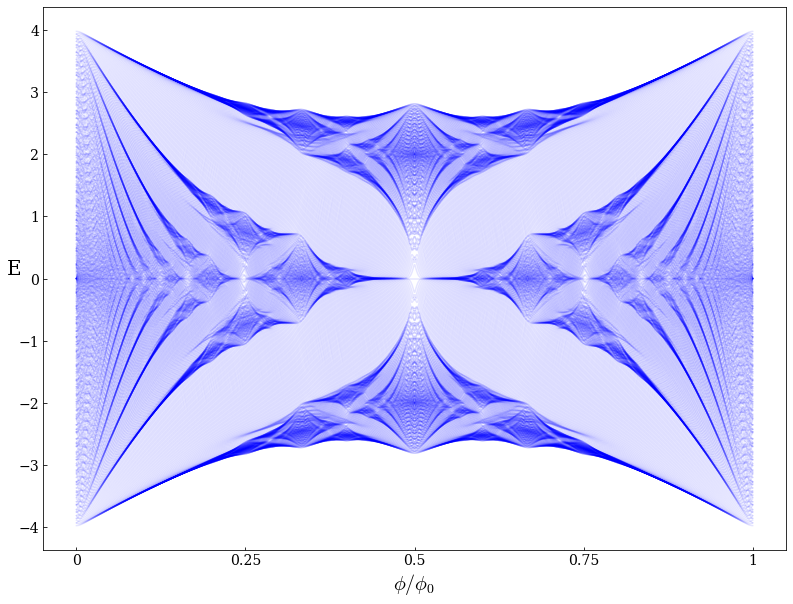

In [11]:
fig, ax = plt.subplots(figsize= (13.33,10))

for y in eigs_banded:
    ax.plot(Bs,y, color= 'b', alpha= 0.1)

max_B = max(Bs)
ax.set_xticks([0, 0.25*max_B, 0.5*max_B, 0.75*max_B, max_B], ['0', '0.25', '0.5', '0.75', '1'])
ax.set_xlabel(r'$\phi / \phi_0$')
ax.set_ylabel('E', rotation= 0)

plt.savefig('../../Illustrations/Periodic_bands.png')
plt.show()

In [5]:
# Saving points, jump indices, and jumps
with open('../../Grids/Periodic_grid.txt', 'w') as file:
    for i in points:
        file.write(f'{i[0]},{i[1]}')
        file.write('\n')

max_length1 = max([len(x) for x in jump_indices])
with open('../../Grids/Periodic_jump_indices.txt', 'w') as file:
    for i in jump_indices:
        if len(i) == max_length1:
            w = i + ['stop']
            for j in range(len(w)):
                file.write(f'{w[j]}')
                file.write(' ')
            file.write('\n')
        else:
            diff = max_length1 - len(i)
            extension = ['stop' for _ in range(0,diff + 1)]
            extended_list = i + extension
            for j in range(len(extended_list)):
                file.write(f'{extended_list[j]}')
                file.write(' ')
            file.write('\n')

max_length2 = max([len(x) for x in jump_coors])
with open('../../Grids/Periodic_jump_coordinates.txt', 'w') as file:
    for i in jump_coors:
        new_list = [f'({x[0]},{x[1]})' for x in i]
        if len(new_list) == max_length2:
            new_list1 = new_list + ['stop']
            for j in range(len(new_list1)):
                file.write(f'{new_list1[j]}')
                file.write(' ')
            file.write('\n')
        else:
            diff = max_length2 - len(new_list)
            extension = ['stop' for _ in range(0,diff + 1)]
            extended_list = new_list + extension
            for j in range(len(extended_list)):
                file.write(f'{extended_list[j]}')
                file.write(' ')
            file.write('\n')